# MLOps demonstration : experimentation

                                     

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint 
from scipy.stats import uniform
import matplotlib.image as mpimg
from skimage.io import imread, imshow
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# Removing warnings for deprecated features etc
import warnings
warnings.filterwarnings("ignore")

## Set up Azure ML workspace connection 

In [3]:
from arcus.azureml.environment.aml_environment import AzureMLEnvironment
from arcus.ml.images import explorer

In [4]:
training_name = 'mnist-logistic-regression'
experiment_name = 'mnist-prep'

#training_name = 'logistic-regression2'
#experiment_name = 'sam-prep2'

In [5]:
azure_config_file = '.azureml/config.json'
aml = AzureMLEnvironment.Create(config_file=azure_config_file)

Connected to AzureML workspace
>> Name: codit-ai-incubators-ml
>> Subscription: c1537527-c126-428d-8f72-1ac9f2c63c1f
>> Resource group: codit-ai-incubators


## MNIST classification
De MNIST ("Modified National Institute of Standards and Technology") is a dataset that is being used a lot to measure and benchmark different classification algorithms.  The dataset contains 10's thousands of images of handwritten numbers.  More information can be found here: http://yann.lecun.com/exdb/mnist/


### Load data

In [6]:
aml_df = aml.load_tabular_dataset('mnist')

In [7]:
training_set_size = 1000
test_set_size = 250
scoring_parameter = "accuracy"
decision_function_shape = "ovr"

df = aml_df.copy()

In [9]:
#Inlezen van de dataset en de trainingsgrootte bepalen
if(training_set_size > 0 and test_set_size > 0):
    df = df.sample(n=training_set_size + test_set_size)

y = df.label.values # The label is what we should predict = the y in the equation
X = np.asarray(df.drop(['label'],axis=1))


In [10]:
if test_set_size <= 0: 
    test_set_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=42)

In [11]:
print(f'Train records: {len(X_train)}')
print(f'Test records: {len(X_test)}')
print(f'Input features: {X_train.shape[1]}')

Train records: 1000
Test records: 250
Input features: 784


## Data demonstration

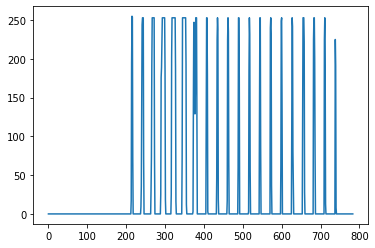

In [14]:
sample_image = X[72].reshape(28,28)
#print(sample_image)
plt.plot(X[1])
plt.show()

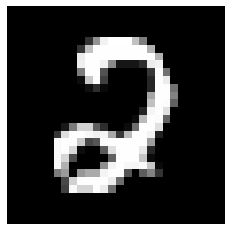

In [15]:
explorer.show_image(sample_image)

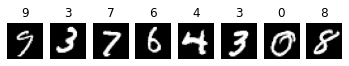

In [16]:
explorer.visualize_classes(X_train.reshape(len(X_train),28,28), y_train, image_count=8)

## Data preparation (scaling)

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

## Model training, local

In [18]:
trainer = aml.start_experiment(experiment_name)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       0.89      0.97      0.93        32
           2       0.96      0.87      0.91        30
           3       0.78      0.75      0.76        28
           4       0.92      0.85      0.88        26
           5       0.73      0.76      0.75        25
           6       0.68      0.76      0.72        17
           7       0.91      0.91      0.91        23
           8       0.71      0.60      0.65        20
           9       0.84      0.87      0.85        30

    accuracy                           0.84       250
   macro avg       0.83      0.83      0.83       250
weighted avg       0.84      0.84      0.84       250

[[19  0  0  0  0  0  0  0  0  0]
 [ 0 31  0  0  0  0  1  0  0  0]
 [ 0  0 26  0  2  0  0  0  2  0]
 [ 0  1  1 21  0  1  3  1  0  0]
 [ 0  0  0  0 22  0  1  0  1  2]
 [ 1  1  0  1  0 19  1  0  1  1]
 [ 0  1  0  0  0  3 13  0  0  0]
 [ 0  0  0

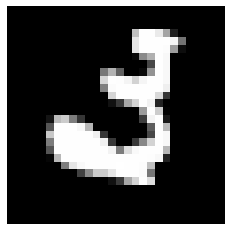

In [18]:
c_value = 0.02
_run = trainer.new_run(f'C={c_value}')
model = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', C=c_value)
model.fit(X_train, y_train)
trainer.evaluate_image_classifier(model, X_test=X_test, y_test=y_test, failed_classifications_to_save=3, finish_existing_run = False, upload_model=False, save_curves_as_image=False, image_shape=(28,28))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       0.89      0.97      0.93        32
           2       0.96      0.87      0.91        30
           3       0.75      0.75      0.75        28
           4       0.92      0.85      0.88        26
           5       0.75      0.72      0.73        25
           6       0.68      0.76      0.72        17
           7       0.88      0.91      0.89        23
           8       0.67      0.60      0.63        20
           9       0.83      0.83      0.83        30

    accuracy                           0.83       250
   macro avg       0.82      0.83      0.82       250
weighted avg       0.83      0.83      0.83       250

[[19  0  0  0  0  0  0  0  0  0]
 [ 0 31  0  0  0  0  1  0  0  0]
 [ 0  0 26  0  2  0  0  0  2  0]
 [ 0  1  1 21  0  1  3  1  0  0]
 [ 0  0  0  0 22  0  1  0  1  2]
 [ 1  1  0  2  0 18  1  0  1  1]
 [ 0  1  0  0  0  2 13  0  1  0]
 [ 0  0  0

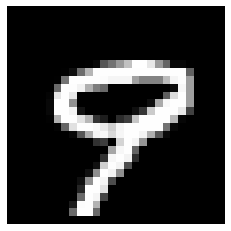

In [19]:
for c_value in [0.01, 1, 5] :
    _run = trainer.new_run(f'C={c_value}')
    model = LogisticRegression(solver='saga', C=c_value)
    model.fit(X_train, y_train)
    trainer.evaluate_image_classifier(model, X_test=X_test, y_test=y_test, failed_classifications_to_save=3, image_shape=(28,28), finish_existing_run = True, upload_model=True, save_curves_as_image=False)
    #trainer.evaluate_classifier(model, X_test, y_test, upload_model = True)

## Model training, docker

In [20]:
trainer = aml.start_experiment(experiment_name)
trainer.setup_training(training_name)

In [21]:
args = {
    '--c_value': 1.02,
    '--solver': 'saga', # lbfgs newton-cg liblinear saga sag
    '--train_test_split_ratio': 0.3
}

compute_run = trainer.start_training(training_name, environment_type='sklearn', 
                       script_parameters=args, use_estimator=True,
                       compute_target='cpu-cluster', gpu_compute=False)

Scheduling Estimator training


WARNING - You have specified to install packages in your run. Note that you have overridden Azure ML's installation of the following packages: ['joblib', 'scikit-learn']. We cannot guarantee image build will succeed.


Creating estimator of type sklearn
https://ml.azure.com/experiments/mnist-prep/runs/mnist-prep_1615567527_19ec9ecc?wsid=/subscriptions/c1537527-c126-428d-8f72-1ac9f2c63c1f/resourcegroups/codit-ai-incubators/workspaces/codit-ai-incubators-ml


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [51]:
for solver in ['lbfgs', 'newton-cg', 'saga']:
    for c_value in np.logspace(0.001, 2, num=5):
        args = {
            '--c_value': c_value,
            '--solver': solver, # lbfgs newton-cg liblinear saga sag
            '--train_test_split_ratio': 0.3
        }


        compute_run = trainer.start_training(training_name, environment_type=None, 
                               script_parameters=args, use_estimator=True,
                               compute_target='gpu-training', gpu_compute=True)

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021551_f10cab05?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021554_3e7c943c?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021556_8ec6c064?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021559_9141f8b3?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021561_31ad0286?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021563_73258fb0?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021565_47fb0f27?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021569_07737a33?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021570_a6b4d00e?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021572_f19e3788?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021574_00a4b0ba?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021578_864d417d?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021581_1d62669f?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021583_19d4e6af?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

Scheduling Estimator training
Creating estimator of type None
https://ml.azure.com/experiments/mnist/runs/mnist_1608021585_6f73f1cf?wsid=/subscriptions/b73995e3-caad-4882-8644-f2175789c3ff/resourcegroups/savanh-time-travel/workspaces/savanh-time-travel


_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

## Deploy ML Model

In [24]:
from azureml.core import Run

def deploy_model(experiment, run_number, model_location):
    for run in experiment.get_runs():
        if run.number == run_number:
            model = run.register_model(model_name=experiment.name,
                           tags={'output': 'number', 'input': 'mnistarray'},
                           model_path=model_location)
            print(model.name, model.id, model.version, sep='\t')
            break
    
deploy_model(trainer._AzureMLTrainer__experiment, 41, 'outputs/mnist_model.pkl')

WARNING - Run Number's semantics may be modified in the future


mnist-prep	mnist-prep:1	1


In [25]:
from azureml.core.model import Model
series_model = Model.list(aml.get_azureml_workspace(), name=experiment_name, latest=True)[0]
print(series_model)

Model(workspace=Workspace.create(name='codit-ai-incubators-ml', subscription_id='c1537527-c126-428d-8f72-1ac9f2c63c1f', resource_group='codit-ai-incubators'), name=mnist-prep, id=mnist-prep:1, version=1, tags={'output': 'number', 'input': 'mnistarray'}, properties={})


In [26]:
Model.get_model_path(training_name)

'mnist-logistic-regression'

## Set up inference cluster

In [27]:
web_service_name= training_name.lower() + '-v1'

In [28]:
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.model import Model

deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1, 
                                                       auth_enabled=True, enable_app_insights=True)
deployment_target = None

In [30]:
print(training_name)

mnist-logistic-regression


In [31]:
from azureml.core import Environment
from azureml.core.model import InferenceConfig
myenv = Environment.get(aml.get_azureml_workspace(), 'logistic-regression')
inference_config = InferenceConfig(entry_script=training_name + '/score.py', environment=myenv)

In [32]:
from azureml.core import Environment
from azureml.core.webservice import Webservice
from azureml.exceptions import ComputeTargetException, WebserviceException

try:
    service = Webservice(name=web_service_name, workspace=aml.get_azureml_workspace())
    print('Web service exists and retrieved')
except WebserviceException:
    print('Deploying model as web service')
    service = Model.deploy(workspace=aml.get_azureml_workspace(), 
                           name=web_service_name, 
                           models=[series_model], 
                           deployment_target=deployment_target,
                           inference_config=inference_config, 
                           deployment_config=deployment_config)
    service.wait_for_deployment(show_output=True)
    print(service.state)
    service.get_logs()    
    print('Web service created')

Deploying model as web service
Running.....................................................................................................................................................................................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
Web service created


## Update scoring script

In [33]:
from azureml.core import Environment
from azureml.core.model import InferenceConfig
print(training_name)
myenv = Environment.get(aml.get_azureml_workspace(), 'logistic-regression')
inference_config = InferenceConfig(entry_script=training_name + '/score.py', environment=myenv)

mnist-logistic-regression


In [34]:
from azureml.core import Environment
from azureml.core.webservice import Webservice

service = Webservice(name=web_service_name, workspace=aml.get_azureml_workspace())

In [35]:
from azureml.core.model import Model
series_model = Model.list(aml.get_azureml_workspace(), name=experiment_name, latest=True)[0]
print(series_model)

Model(workspace=Workspace.create(name='codit-ai-incubators-ml', subscription_id='c1537527-c126-428d-8f72-1ac9f2c63c1f', resource_group='codit-ai-incubators'), name=mnist-prep, id=mnist-prep:1, version=1, tags={'output': 'number', 'input': 'mnistarray'}, properties={})


In [36]:
service.update(models=[series_model], inference_config=inference_config, enable_app_insights=True)

In [37]:
service.wait_for_deployment(show_output=True)

Running......................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
